# COVID-19 impact on NYC Citi Bike Rentals Revenue 
<br/>

<img src="../img/2bikes.png"
     alt="Citi Bike with the Empire State Building in the background"
     style="float: right; margin-left: 16px;"
     width="450"/>

Citi Bike is a private-owned bicycle sharing sharing system that serves the New York City and parts of Bronx, Brooklyn, Manhattan, Queens and Jersey City. With 332 stations and 6,000 bikes it officially launched in May 2013. As of October 2017, annual advancements makes the total to 706 stations and 12,000 bikes, attempting to make the business the biggest bike-sharing system in the United States. Further expansions are scheduled for Citi Bike to enhance its service area across the Bronx, Brooklyn, Manhattan and Queens and to raise the capacity of bikes to 40,000.

New york is one of the major cities in USA that has been dreadfully been affected by Covid-19 and New York state is slowly emerging from the shelter-in-place order issued on March 22 to prevent the spread of Covid-19.It remains to be seen just how long it will take for things to truly get back to normal. In the meantime, I thought it would be interesting to analyze bike rental data from 2019 and 2020 to see what effect, if any, the pandemic has had on NYC's bike share program.
Data Source :https://www.citibikenyc.com/system-data


<br/>


     
<br/>

## 1. A Tale of 12 million rows
<br/>

From a data science perspective, there are at least three great things about bike share programs:

1. They *usually* share a good portion of their data freely with the public
2. The data is *mostly* clean and ready to go for analysis
3. They can be a great source for getting *a lot* of data for a project (\**depending on the program*)



Citi Bike is no exception to the above, providing their data in a few different formats if you want to dig in and learn more. 


### The data

The data files are available in csv format with the following fields:

- `Trip Duration` : Lenght of trip (seconds)
- `Start Time and Date` : Start time of the rental
- `Stop Time and Date` : End time of the rental
- `Start Station Name` : self explanatory
- `End Station Name` : self explanatory
- `Station ID : Unique` Id for each station
- `Station Lat/Long` : self explanatory
- `Bike ID` : Unique ID for all the bikes
- `User Type` : Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member
- `Gender` : Zero=unknown; 1=male; 2=female
- `Year of Birth` : self explanatory

### The analysis

For this project, I am interested in comparing data between 2019 and 2020 to investigate the impact of Covid-19 on bike share program revenue. Since June data is not yet available (at the time of writing), I will focus on the period between January and May for both 2019 and 2020. This will provide over 12 million rows of data for our analysis.

#### The primary questions I seek to answer with this research are:
    
&nbsp;&nbsp;**1.** What is the effect, if any, of Covid-19 on the total number of bike rentals and average rentals per day?
<br/>

&nbsp;&nbsp;**2.** What is the effect, if any, of Covid-19 on the average bike rental duration?
<br/>

&nbsp;&nbsp;**3.** Are there any significant, observable patterns in the data along the dimensions of Age or Gender?
<br/>

&nbsp;&nbsp;**4.** Are there any perceptible shifts in rider behavior in terms of rides by hour of day or day of the week?
<br/>

&nbsp;&nbsp;**5.** Based on the above analysis and a simplified model for rental pricing, what is the estimated effect on program revenue in 2020?
<br/>

#### Hypothesis
The global impacts of Covid-19 are widespread and unprecedented in modern history. In the US alone, the pandemic has resulted in significant job loss (unemployment sits at 13.3% as of June 5, 2020), and for those lucky enough to still be employed, significant changes in workplace requirements. In an effort to stop the spread of Covid-19 among workers, many employers have shifted either temporarily or permanently, to a remote, work-from-home (WFH) style of operations. 

These massive, nearly instantaneous spikes in unemployment and in remote work have resulted in changes to commuting behavior and a reduction in overall traffic volumes. Further, in many cities (including NYC), public transportation options have been temporarily reduced or shut down completely for various periods of time. In addition to these changes in the work place and to commuting behaviors and options, the *Shelter in Place* order issued on March 22, 2020 encouraged all New Yorkers to stay home and to avoid travel in public unless absolutely necessary.

Given this combination of changes in employment, work place location, commuting behaviors and public health dangers, it stands to reason that the Citi Bike program would experience a reduction in overall bike rentals and by extension, program revenue. 

Therefore, my hypothesis is as follows:
- **Citi Bike program revenue is down in 2020 when compared to 2019.**  
<br/>

Let's dig into the data and find out!


### Import packages


In [5]:
import os
import glob
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Set display option for floats in Pandas

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='ticks', color_codes=True, font_scale=1.25)

In [105]:
os.getcwd()
os.chdir("C:\\Users\\roshi\\Downloads\\new_data")


### Create some user defined functions for reading and processing the data

One lesson I learned pretty quickly on this project was that creating a dataframe with 12+ million rows of data can eat up memory quickly. My initial attempt to read in and concatenate all the files resulted in a massive dataframe utilizing over <ins>**4+ GB**</ins> of my system memory. Needless to say, this brought my analysis to a halt. Determined to press on, I did some research on memory usage in Pandas and Jupyter Notebook and found a few strategies I thought might help.

<br/>
There are some great resources out there if you want to read more about the topic. I relied on this [article](https://www.dataquest.io/blog/pandas-big-data/) from DataQuest to get me pointed down the right path. If I had to sum this up into a couple of key nuggets though, they would be:

1. **Dtype matters** <br/> Optimizing your dtypes can result in up to 75% savings in memory usage in the right circumstances.
<br/>

2. **Dtype especially matters if it's an object** <br/> Storing column data as an object dtype is pretty much the least efficient way to go when it comes to memory usage. Change to a more optimized dtype if at all possible.
<br/>

3. **Only keep the data you need** <br/> See points made directly above... if you aren't using the data for your analysis, don't keep it.
<br/>

4. **A pivoted dataframe will speed up your plots** <br/> For my analysis, I'm looking for broad trends in the data. I don't need to plot every point. Your mileage may vary based on the needs of your project, but a pivoted dataframe with ~100 rows of data will plot faster than 12 million rows any day of the week.
<br/>

The following helper function facilitates optimizing the files during the read-in process primarily by changing dtypes and dropping unnecessary columns. After optimization, I managed to get the overall memory usage down to just over 1 GB from the original ~4 GB, which greatly improved performance.
<br/>

In [8]:
# Function for reading in and processing data files
def read_and_process(filepath, col_types, drop_cols):
    '''Reads in and processes CitiBike monthly csv data files and returns a 
    dataframe containing the list of rentals for a given month
    '''
    # Read in the data
    temp_df = pd.read_csv(filepath) 
    
    # Drop rows with null values
    temp_df = temp_df.dropna()
    
    # Convert starttime columns to datetime
    temp_df.starttime = pd.to_datetime(temp_df.starttime, infer_datetime_format=True)
    
    # Convert usertype column to binary
    temp_df.usertype = temp_df.usertype.map({"Subscriber": 0, "Customer": 1})
    
    # Convert column dtypes
    temp_df = temp_df.astype(col_types)
    
    # Drop unnecessary or redundant columns
    temp_df = temp_df.drop(drop_cols, axis=1)
    
    # Rename columns to replace spaces with "_"
    temp_df.columns = temp_df.columns.str.replace(" ", "_")
    
    return temp_df

### Prep for import and read in the data

Now that we have the helper function to get us started, we're ready to read in the data files. First we will create a few variables required for input into the **read_and_process** function and then it's off to the races. (Actually, this part take a couple of minutes to complete, so see you on the other side.)

TODO - What fields are being transformed or dropped, and why?

In [59]:
# Dictionary of columns and optimal dtypes
col_types = {'start station id' : 'int', 'end station id': 'int',
             'usertype': 'int8', 'birth year': 'int', 'gender': 'int8'}

# Create list of columns to drop
drop_cols = ['stoptime', 'start station name', 'start station latitude', 'start station longitude',
             'end station name', 'end station latitude', 'end station longitude', 'bikeid']

# Read in and process the data
data_files = glob.glob('../new_data/' + "*.csv")
rentals_dfs = []

for file in data_files:
    rentals_df = read_and_process(file, col_types, drop_cols)
    rentals_dfs.append(rentals_df)

# Concatentate the list of temp dfs
df_main = pd.concat(rentals_dfs, ignore_index=True)

# Check out the data!
rows = df_main.shape[0]
print(str(rows) + " Rows")

12556146 Rows



### Data preview and cleanup

Next, let's spend some time previewing and cleaning the data before generating the final dataframe for analysis. First, we'll take a look at some of the descriptive statistics to get a feel for the overall data quality.


In [60]:
#Having two dataframes;I'll be working on the copy and leave the main file untouched
df=df_main
# Review the descriptive stats
df.describe()

,tripduration,start_station_id,end_station_id,usertype,birth_year,gender
count,12556146.00,12556146.00,12556146.00,12556146.00,12556146.00,12556146.00
mean,1055.92,1744.07,1735.19,0.14,1979.82,1.17
std,11043.14,1492.98,1492.78,0.34,12.22,0.54
min,61.00,72.00,72.00,0.00,1857.00,0.00
25%,356.00,391.00,389.00,0.00,1969.00,1.00
50%,622.00,522.00,520.00,0.00,1982.00,1.00
75%,1144.00,3324.00,3323.00,0.00,1990.00,1.00
max,3786187.00,4021.00,4021.00,1.00,2004.00,2.00


#### Summary and next steps
Looking at the descriptive statistics, it appears we may need to do some additional processing on the **tripduration** and **birth_year** columns, so we'll take a look at those individually starting with the tripduration column.


### Trip duration review

The raw data from Citi Bike includes tripduration in the unit of seconds. Based on the output above, we can see that the minimum trip is just over one minute and the maximum trip clocks in at **over 63,000 minutes**! In addition, the standard deviation for the column seems high (~185 minutes) given that the 75th percentile is sitting at about 20 minutes.

Let's review the distribution to decide how to move forward.

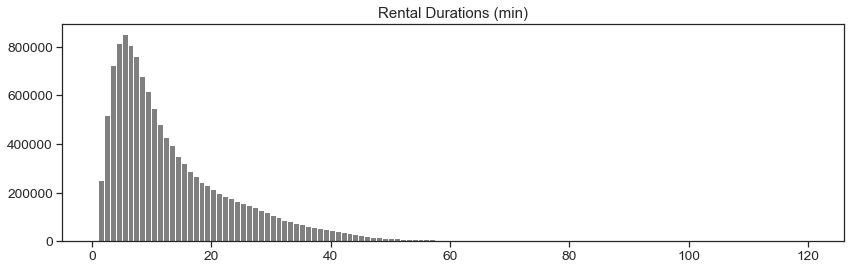

In [65]:
# Convert durations to minutes
x = df.tripduration / 60

# Plot as a histogram with a range up to 2 hours
plt.figure(figsize=(14,4))
plt.hist(x, bins=120, range=(1,120), color='darkblue')
plt.title('Rental Durations (min)')
plt.savefig('../new_data/figures/hist_tripduration.png');


#### Duration distribution results

Based on the histogram, it looks like our distribution is skewed heavily to the right which makes sense given the descriptive statistics we observed above. From this view, it appears that the number of trips starts to drop off almost entirely at the 60 minute mark. 

In addition, there are a high number of trips on the lower end of the range (i.e., close to 1 minute). We can investigate these trips as well to see if there is a possibility of outliers on the low end.

Let's drill in and see what percentage of trips are greater than 2 hours in length or less than 5 minutes.

In [66]:
# Get a count of the number of trips over 60 minutes and 2 hours
trips_over_60 = df.tripduration[df.tripduration > 3600].count() / df.tripduration.count()
trips_over_90 = df.tripduration[df.tripduration > 5400].count() / df.tripduration.count()
trips_over_120 = df.tripduration[df.tripduration > 7200].count() / df.tripduration.count()

print("The percentage of trips over 60 minutes is " + str(round((trips_over_60 * 100),2)) + "%")
print("The percentage of trips over 90 minutes is " + str(round((trips_over_90 * 100),2)) + "%")
print("The percentage of trips over 120 minutes is " + str(round((trips_over_120 * 100),2)) + "%")

The percentage of trips over 60 minutes is 1.4%
The percentage of trips over 90 minutes is 0.65%
The percentage of trips over 120 minutes is 0.4%


In [67]:
# Get a count of the number of trips under 2 minutes and 5 minutes
trips_under_90sec = df.tripduration[df.tripduration < 90].count() / df.tripduration.count()
trips_under_2 = df.tripduration[df.tripduration < 120].count() / df.tripduration.count()
trips_under_5 = df.tripduration[df.tripduration < 300].count() / df.tripduration.count()

print("The percentage of trips under 90 seconds is " + str(round((trips_under_90sec * 100),2)) + "%")
print("The percentage of trips under 2 minutes is " + str(round((trips_under_2 * 100),2)) + "%")
print("The percentage of trips under 5 minutes is " + str(round((trips_under_5 * 100),2)) + "%")

The percentage of trips under 90 seconds is 0.74%
The percentage of trips under 2 minutes is 2.02%
The percentage of trips under 5 minutes is 18.66%



#### Identifying outliers

On the upper end of duration, almost one and a half percent of trips exceed an hour with less than half of a percent of trips exceeding 2 hours. Things get a bit more interesting on the lower end of the spectrum where two percent of trips clock in at less than 2 minutes with **almost one percent under 90 seconds!** This seems like a very short trip to make on a rental bike and hardly worth the effort of renting. 

Since the goal of the analysis is to look for differences between 2019 and 2020, let's compare the data between years before making a final decision about which data to keep and which to cut.

In [68]:
# Compare 2019 trips to 2020
pct_2019_under_90 = df[(df.starttime < '2020-01-01 00:00:00') & (df.tripduration < 90)].\
               tripduration.count() / df[df.starttime < '2020-01-01 00:00:00'].tripduration.count()
pct_2020_under_90 = df[(df.starttime > '2019-12-31 23:59:59') & (df.tripduration < 90)].\
               tripduration.count() / df[df.starttime > '2019-12-31 23:59:59'].tripduration.count()
print("2019 Under 90 sec: " + str(round((pct_2019_under_90 * 100),5)) + "%")
print("2020 Under 90 sec: " + str(round((pct_2020_under_90 * 100),5)) + "%")
print("\n")

pct_2019_over_120 = df[(df.starttime < '2020-01-01 00:00:00') & (df.tripduration > 7200)].\
               tripduration.count() / df[df.starttime < '2020-01-01 00:00:00'].tripduration.count()
pct_2020_over_120 = df[(df.starttime > '2019-12-31 23:59:59') & (df.tripduration > 7200)].\
               tripduration.count() / df[df.starttime > '2019-12-31 23:59:59'].tripduration.count()
print("2019 Over 2 hr: " + str(round((pct_2019_over_120 * 100),5)) + "%")
print("2020 Over 2 hr: " + str(round((pct_2020_over_120 * 100),5)) + "%")

2019 Under 90 sec: 0.71007%
2020 Under 90 sec: 0.77604%


2019 Over 2 hr: 0.27915%
2020 Over 2 hr: 0.55759%


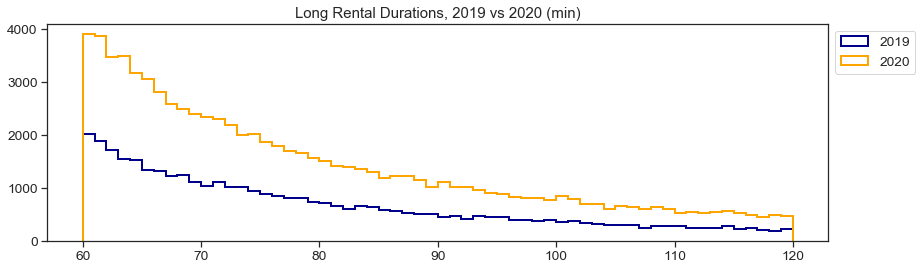

In [70]:
# Filter to long rentals 
long_trips_2019 = df[(df.starttime < '2020-01-01 00:00:00') & (df.tripduration >= 3600) & (df.tripduration <= 7200)]
long_trips_2020 = df[(df.starttime > '2019-12-31 23:59:59') & (df.tripduration >= 3600) & (df.tripduration <= 7200)]

# Convert durations to minutes
x1 = long_trips_2019.tripduration / 60
x2 = long_trips_2020.tripduration / 60

# Plot as a histogram
plt.figure(figsize=(14,4))
plt.hist(x1, bins=60, range=(60,120), color='orange', histtype='step', linewidth=2, fill=False, label='2019')
plt.hist(x2, bins=60, range=(60,120), color='orange', histtype='step', linewidth=2, fill=False, label='2020')
plt.title('Long Rental Durations, 2019 vs 2020 (min)')
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('../new_data/figures/hist_tripduration2.png');


#### Removing outliers

There is a slight difference in the percentage of trips under 90 seconds and over 2 hours when comparing 2019 and 2020, but it seems insignificant enough (~0.066% on the low end and ~0.28% on the high end, respectively) as to not affect our final results. The distribution of trips in the 60-120 minute range shows a consistent trend of nearly twice as many trips in 2020 versus 2019 over this range of durations. This could be indicative of a trend toward longer rental durations in 2020 and if we set the cut off lower than 120 minutes, we could miss this trend in the later analysis.    

Based on these results, we'll remove outlier trips that are **under 90 seconds** and **over two hours**. Afterwards, we can move on to review and clean up the birth year data.

In [22]:
# Remove outlier trips > 120 min or < 90 seconds in duration
df = df[(df.tripduration >= 90)]
df = df[(df.tripduration <= 7200)]


### Birth year review

Revisiting the descriptive statistics above, we see a spread of birth years ranging from 1857-2004. While it definitely feels likely that there are riders as young as 16, it's doubtful we have riders who are **163 years old**.

Again, let's start with a histogram view and then decide on next steps.

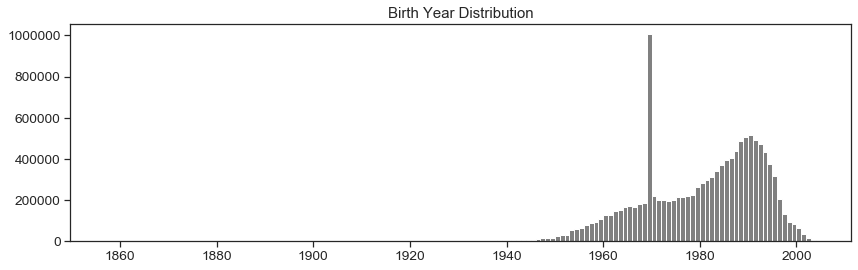

In [24]:
# Convert durations to minutes
x = df.birth_year

# Plot as a histogram with a range up to 2 hours
plt.figure(figsize=(14,4))
plt.hist(x, bins=147, range=(1857,2004), color='darkblue')
plt.title('Birth Year Distribution')
plt.savefig('../new_data/figures/hist_birth_year.png');

In [25]:
# Calculate the percent of rows with riders older than 90
pct_over_90 = round((df[df.birth_year < 1930].birth_year.count() / df.birth_year.count() * 100),2)
print("Overall percent of riders over 90 years of age: " + str(pct_over_90) + "%")

pct_2019_over_90 = df[(df.starttime < '2020-01-01 00:00:00') & (df.birth_year < 1930)].\
               birth_year.count() / df[df.starttime < '2020-01-01 00:00:00'].tripduration.count()
pct_2020_over_90 = df[(df.starttime > '2019-12-31 11:59:59') & (df.birth_year < 1930)].\
               birth_year.count() / df[df.starttime > '2019-12-31 11:59:59'].tripduration.count()
print("2019 percent of riders over 90 years of age: " + str(round((pct_2019_over_90 * 100),5)) + "%")
print("2020 percent of riders over 90 years of age: " + str(round((pct_2020_over_90 * 100),5)) + "%")

Overall percent of riders over 90 years of age: 0.06%
2019 percent of riders over 90 years of age: 0.06095%
2020 percent of riders over 90 years of age: 0.05561%


#### Removing outliers

For birth-year, we could consider replacing the outlier values by imputing with the column average or by some other means. But, given that the number of rows with riders over 90 years old is relatively small overall and is consistent between 2019 and 2020, we should be safe to remove these completely.

There is another, more interesting spike in the distribution right around 1969. After removing the outlier age range, let's take a look at the spike in greater detail. 

In [26]:
# Remove outlier trips with riders older than 90
df = df[df.birth_year >= 1930]

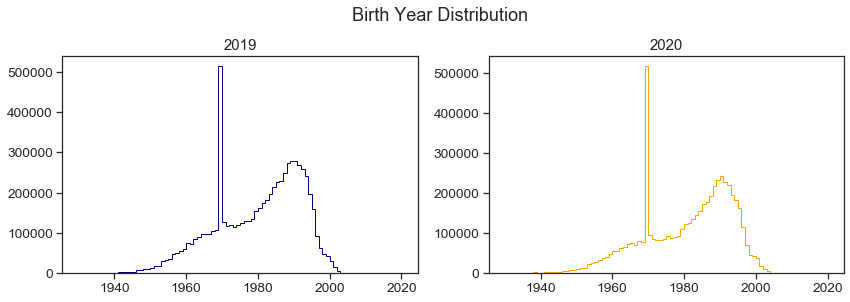

In [71]:
# Filter by year
x1 = df[(df.starttime < '2020-01-01 00:00:00')].birth_year
x2 = df[(df.starttime > '2019-12-31 23:59:59')].birth_year

# Plot as a histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
plt.suptitle('Birth Year Distribution', y=1.05)
ax1.hist(x1, bins=90, range=(1930,2020), color='darkblue', histtype='step', fill=False, label='2019')
ax1.set_title('2019')
ax2.hist(x2, bins=90, range=(1930,2020), color='orange', histtype='step', fill=False, label='2020')
ax2.set_title('2020')
plt.savefig('../new_data/figures/hist_birth_year2.png', bbox_inches='tight');

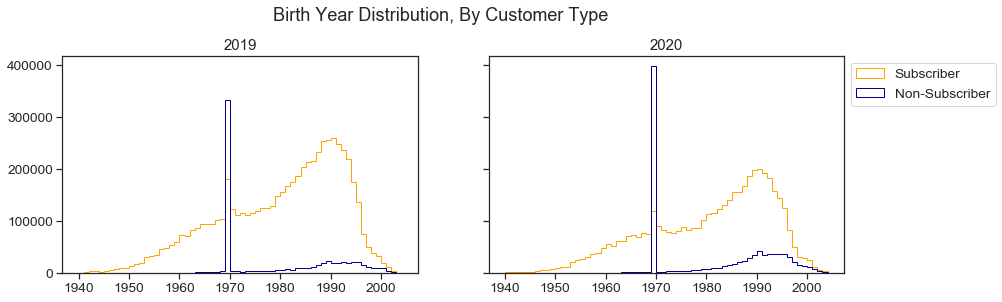

In [72]:
###TODO - Refactor to simplify code
# Filter by year and customer type
x1 = df[(df.starttime < '2020-01-01 00:00:00') & (df.usertype == 0)].birth_year
x2 = df[(df.starttime < '2020-01-01 00:00:00') & (df.usertype == 1)].birth_year
x3 = df[(df.starttime > '2019-12-31 23:59:59') & (df.usertype == 0)].birth_year
x4 = df[(df.starttime > '2019-12-31 23:59:59') & (df.usertype == 1)].birth_year

# Plot as a histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4), sharey='row')
plt.suptitle('Birth Year Distribution, By Customer Type', y=1.05)
ax1.hist(x1, bins=64, range=(1940,2004), color='orange', histtype='step', fill=False, label='Subscriber')
ax1.hist(x2, bins=64, range=(1940,2004), color='darkblue', histtype='step', fill=False, label='Non-Subscriber')
ax1.set_title('2019')
ax2.hist(x3, bins=64, range=(1940,2004), color='orange', histtype='step', fill=False, label='Subscriber')
ax2.hist(x4, bins=64, range=(1940,2004), color='darkblue', histtype='step', fill=False, label='Non-Subscriber')
ax2.set_title('2020')
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('../new_data/figures/hist_birth_year_3.png', bbox_inches='tight');

In [73]:
# Calculate the percent of rows with riders born in 1969
pct_born1969 = round((df[df.birth_year == 1969].birth_year.count() / df.birth_year.count() * 100),2)
print("Overall percent of riders born in 1969: " + str(pct_born1969) + "%")

pct_2019_born1969 = df[(df.starttime < '2020-01-01 00:00:00') & (df.birth_year == 1969)].\
               birth_year.count() / df[df.starttime < '2020-01-01 00:00:00'].birth_year.count()
pct_2020_born1969 = df[(df.starttime > '2019-12-31 11:59:59') & (df.birth_year == 1969)].\
               birth_year.count() / df[df.starttime > '2019-12-31 11:59:59'].birth_year.count()
print("2019 percent of riders born in 1969: " + str(round((pct_2019_born1969 * 100),5)) + "%")
print("2020 percent of riders born in 1969: " + str(round((pct_2020_born1969 * 100),5)) + "%")

Overall percent of riders born in 1969: 8.21%
2019 percent of riders born in 1969: 7.4159%
2020 percent of riders born in 1969: 9.18489%



#### Baby boom in 1969??

This is tough to explain with the data we have to available for analysis, but there appears to be a huge spike in riders with a birth year of 1969 consistent in both 2019 and 2020. Reviewing by customer type (subscriber vs. non-subscriber), the spike is visible in both populations, but is much more dramatic for non-subscribers. Unfortunately, we don't have much additional user-specific information to help in determining why this is the case.

Some possible explanations:
1. 1969 is the default birth year on the registration form (doubtful)
<br/>

2. Generally, people have some affinity for the year 1969 (possible)
<br/>

3. Older riders are less likely to be honest about their true birth year (possible)
<br/>

4. There is a price break or discount for riders older than 50 (probable)
<br/>

Number 4 is my best guess, but a quick Google search didn't turn up any results related to a discount for riders 50+. In any case, this brings us to a decision point. If we remove all or most of the rows with this birth year, we lose nearly 10% of our data. If we assign random birth years to these rows based on our distribution, we run the risk of skewing any age-related analysis. For now, let's leave this alone and flag it as something to revisit when we get to analyzing rider behavior by age group. 

#### Checking for correlation

Before moving on to the final cleanup steps, let's review our current dataframe for correlation to see check for any interesting relationships between variables. 

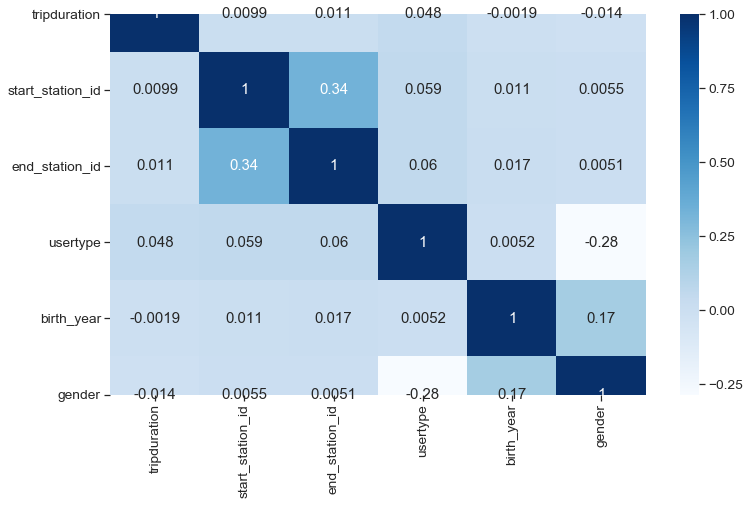

In [74]:
# Create correlation matrix
fig, ax = plt.subplots(figsize=(12, 7))  
sns.heatmap(df.corr(), annot=True, cmap="Blues");
plt.savefig('../new_data/figures/corr_matrix.png', bbox_inches='tight');


#### Correlation results

Even with our skewed birth_year data, there really doesn't appear to be much of a relationship between our different variables. There is a slight positive correlation between `start_station_id` and `end_station_id` which would make sense if people tend to follow the same routes repeatedly (e.g., when commuting). There is a similar positive correlation between `usertype` and `tripduration`. 

Since we don't have any significant positive or negative correlations in the data, let's move on to finalizing the dataframe. Time permitting, we can look into the slight positive correlations later or as a TODO for further analysis.



### Additional columns to aid analysis

To facilitate our analysis and to help in our plotting throughout, we'll add a few more columns for rental count and for date related info (hour, day, month, year and day-of-the-week). 

If memory is at a premium, why add these columns now? The simple answer is that these columns will make pivoting the data much easier throughout the notebook. And, since they all go in as int columns, the additional size will be somewhat negligible. Additionally, once we've extracted this data we'll be able to drop the `starttime` column to reclaim some memory.

(Note - I could do more to optimize the specific type of int column - int8, int16, int32, etc. - but in playing around with this, I didn't see much improvement in overall performance.)

Following this step, we'll have our final dataframe ready to go for analysis.

In [75]:
# Sort the dfs by starttime
df = df.sort_values(by=['starttime']).reset_index(drop=True)

# Create a column to facilitate totaling rental count
df['rental_count'] = 1

# Create a function to get the dow of the week as an int value
def get_dow(starttime):
    """Returns 0 for weekdays or 1 for weekend days when passed a datetime object
    """
    if starttime.weekday() < 5:
        return 0
    else:
        return 1

# Create additional date-related columns
df['hour'] = df.starttime.dt.hour
df['day'] = df.starttime.dt.day
df['month'] = df.starttime.dt.month
df["year"] = df.starttime.dt.year
df['dow'] = df.starttime.apply(get_dow)

# Drop column not used in analysis
df = df.drop(['starttime', 'start_station_id', 'end_station_id'], axis=1)

# Preview final df
df.head()

,tripduration,usertype,birth_year,gender,rental_count,hour,day,month,year,dow
0,320,0,1971,1,1,0,1,1,2019,0
1,316,0,1964,1,1,0,1,1,2019,0
2,591,0,1987,1,1,0,1,1,2019,0
3,2719,0,1990,1,1,0,1,1,2019,0
4,303,0,1979,1,1,0,1,1,2019,0



## 2. So... how does a global pandemic affect the number of bike rentals?
<br/>

Now that we have the final dataframe, we can dig into the analysis. The first question on the list is... What is the effect, if any, of Covid-19 on the total number of bike rentals and average rentals per day?

Before we go further though, we'll create an additional helper function for pivoting the dataframe which will help speed up our plotting from here on out. 

In [76]:
# Function for pivoting dataframe for plotting
def pivot_df(df, pv_index, pv_columns, pv_values, scale, aggfunc=np.sum, impute=False, cumsum=False):
    """Returns a pivoted version of a dataframe to aid in plotting
    """
    # Create pivot table
    df_pivot = df.pivot_table(index=pv_index, columns=pv_columns, values=pv_values, aggfunc=aggfunc)

    # Impute values for 2019-02-29 to account for leap year in 2020 
    if impute == True:
        df_pivot = df_pivot.fillna(df_pivot[2019].mean())

    # Convert to running total
    if cumsum == True:
        df_pivot = df_pivot.cumsum()  
                
    # Scale values 
    df_pivot = df_pivot.apply(lambda x: round((x * scale),2), axis=1)
    
    return df_pivot


### Rentals per month, total and average


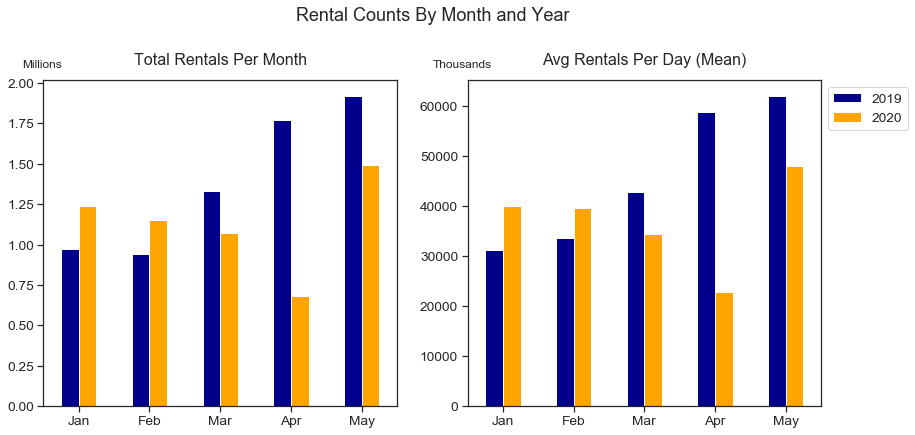

In [77]:
# Pivot df using helper function 
df_pivot_tot = pivot_df(df, ['month'], ['year'], 'rental_count', 0.000001) # total rental count per month

df_pivot_avg = pivot_df(df, ['month', 'day'], ['year'], 'rental_count', 1) # avg rental count per month
df_pivot_avg = df_pivot_avg.pivot_table(index=['month'], values=[2019, 2020], aggfunc=np.mean)

# Rename index to friendly month names
df_pivot_tot.rename(index={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May'}, inplace=True)
df_pivot_avg.rename(index={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May'}, inplace=True)

# Plot the results
fig = plt.figure(figsize=(12, 6))
plt.subplots_adjust(left=0.05, right=0.95)

ax1 = fig.add_subplot(121)
df_pivot_tot.plot(kind='bar', rot=0, color=['darkblue', 'orange'], ax=ax1, legend=False)
ax1.set_xlabel(None)
ax1.set_title('Total Rentals Per Month', pad=16, fontsize=16)

ax2 = fig.add_subplot(122)
df_pivot_avg.plot(kind='bar', rot=0, color=['darkblue', 'orange'], ax=ax2)
ax2.set_xlabel(None)
ax2.set_title('Avg Rentals Per Day (Mean)', pad=16, fontsize=16)

# Set title, text labels and legend
plt.suptitle('Rental Counts By Month and Year', y=1.05, fontsize=18)
plt.text(0.025, 0.91, 'Millions', fontsize=12, transform=plt.gcf().transFigure)
plt.text(0.5, 0.91, 'Thousands', fontsize=12, transform=plt.gcf().transFigure)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('../new_data/figures/bar_rentals_per_month', bbox_inches='tight');

#### A decline in total rentals and average daily rentals in 2020
Total rentals per month and average daily rentals follow similar trends in both 2019 and 2020, and we do see a noticeable dropoff starting in March of 2020 and continuing through April. Rental counts bounce back in May, but still appear to be 10-15% under 2019 levels. 


### Running total of rentals by day, year-over-year

Next, let's drill into **total cumulative rental counts, by day** to see if we can detect the point that rental numbers started dropping off. For this plot, I've added vertical lines corresponding with a couple of key dates related to Covid-19.

- **March 11** - Covid-19 Declared a Global Pandemic
- **March 22** - New York state under order to *shelter-in-place*


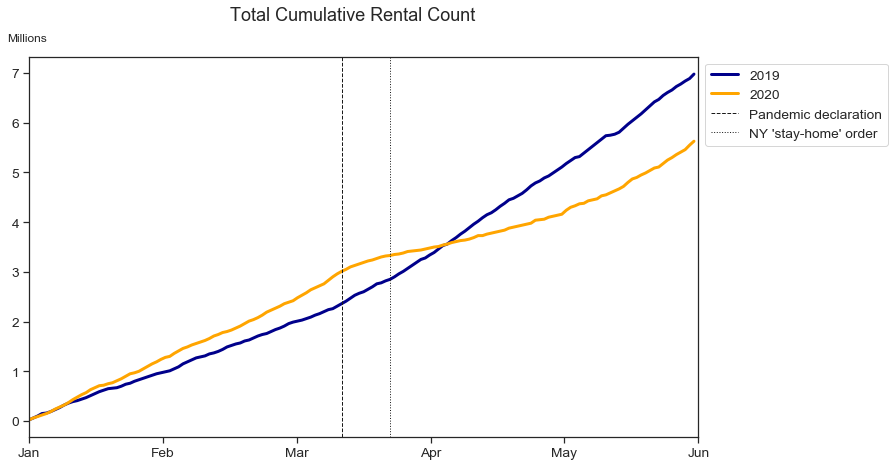

In [78]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month', 'day'], ['year'], 'rental_count', 1.00E-6, cumsum=True, impute=True)

# Plot a line chart and set the chart style
df_pivot.plot(kind='line', linewidth=3, figsize=(12, 7), color=['darkblue', 'orange'])

# Plot vertical lines for key dates
plt.axvline(x=71, color='k', linestyle='--', linewidth=1, label="Pandemic declaration")
# plt.text(25,6,'Covid declared pandemic',rotation=0, fontsize=14, color='k')
plt.axvline(x=82, color='k', linestyle=':', linewidth=1, label="NY 'stay-home' order")
# plt.text(83.5,6.5,'NY \'stay-home\' order',rotation=0, fontsize=14, color='k')

# Add labels and legend
plt.text(0.1, .91, 'Millions', fontsize=12, transform=plt.gcf().transFigure)
plt.suptitle("Total Cumulative Rental Count", fontsize=18)
plt.xticks(np.linspace(0, 152, num=6), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
plt.xlabel(None)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('../new_data/figures/line_cumulative_rentals.png', bbox_inches='tight');

#### Shelter-in-place = fewer bike rentals

This view provides a nice picture regarding the timing of the downward trend starting in mid-March and continuing through April. A slight decline is apparent shortly after the pandemic declaration, with a more noticeable shift starting just before, and continuing after, the stay-at-home decree. In this view, we can also see a slow recovery starting in early May with continued slight improvements through the rest of the month.



## 3. What is the effect on rental durations?
<br/>

The trend with respect to the number of rentals seems to be clear. Based on this trend alone, we have good evidence to support the hypothesis established at the beginning... that Citi Bike program revenue will be down in 2020 when compared to Covid-19. However, revenue is generated both by the number of rentals and to a certain extent, by rental durations. 

Next, we will move on to our second question above... What is the effect, if any, of Covid-19 on the average bike rental duration? Let's complete a similar analysis for durations to see if the trends line up with those we observed for rental counts. 



### Rental duration per month, total and average


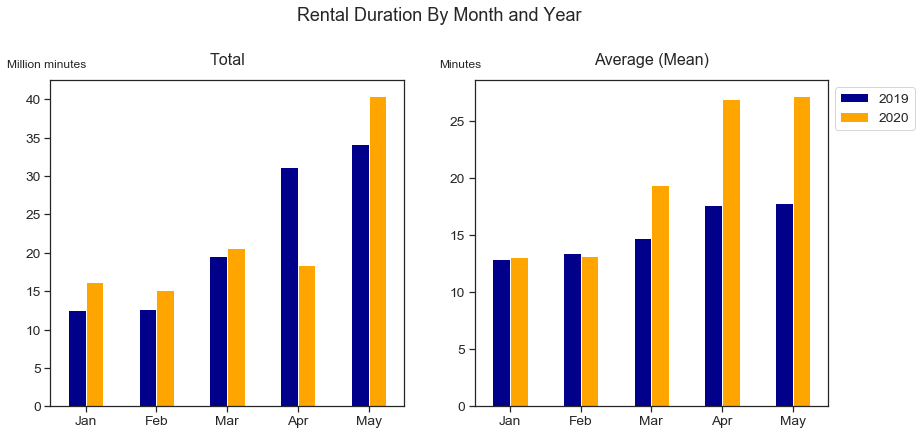

In [79]:
# Pivot df using helper function 
df_pivot_tot = pivot_df(df, ['month'], ['year'], 'tripduration', 1.667E-8, impute=True)
df_pivot_avg = pivot_df(df, ['month'], ['year'], 'tripduration', 1.667E-2, aggfunc=np.mean)

# Rename index to friendly month names
df_pivot_tot.rename(index={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May'}, inplace=True)
df_pivot_avg.rename(index={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May'}, inplace=True)

# Plot the results
fig = plt.figure(figsize=(12, 6))
plt.subplots_adjust(left=0.05, right=0.95)

ax1 = fig.add_subplot(121)
df_pivot_tot.plot(kind='bar', rot=0, color=['darkblue', 'orange'], ax=ax1, legend=False)
ax1.set_xlabel(None)
ax1.set_title('Total', pad=16, fontsize=16)

ax2 = fig.add_subplot(122)
df_pivot_avg.plot(kind='bar', rot=0, color=['darkblue', 'orange'], ax=ax2)
ax2.set_xlabel(None)
ax2.set_title('Average (Mean)', pad=16, fontsize=16)

plt.suptitle('Rental Duration By Month and Year', y=1.05, fontsize=18)
plt.text(0, 0.91, 'Million minutes', fontsize=12, transform=plt.gcf().transFigure)
plt.text(0.5, 0.91, 'Minutes', fontsize=12, transform=plt.gcf().transFigure)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('../new_data/figures/bar_rental_duration_per_month.png', bbox_inches='tight');

#### Total duration bounces back as average duration sees a steady increase
In terms of total duration per month, we see a similar trend in April of 2020 to what we observed with total rentals. In May however, total rental duration bounces back quickly to surpass the same period in 2019. We see a different, unexpected trend in average rental duration per month with a steady increase in average duration starting in March and continuing through May. 


### Total cumulative rental duration over time
Next, let's take a look at the numbers for cumulative rental duration by day between 2019 and 2020 in the context of our key dates related to Covid-19.


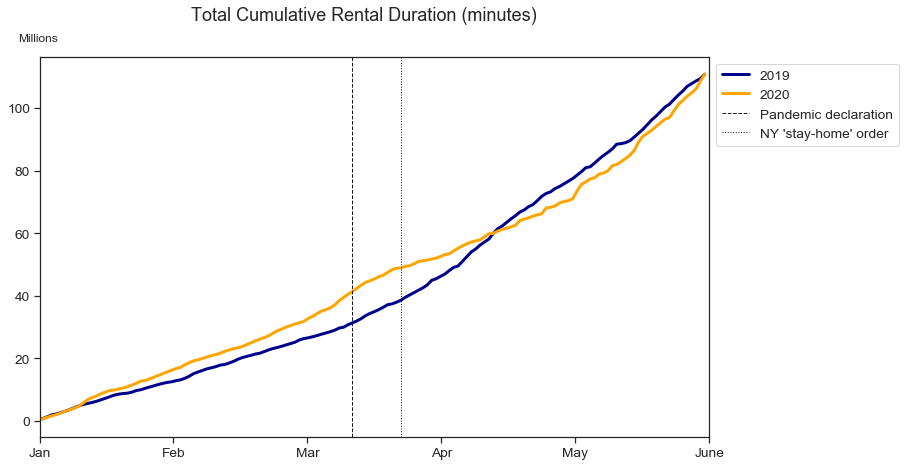

In [80]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month', 'day'], ['year'], 'tripduration', 1.667E-8, cumsum=True, impute=True)

# Plot a line chart and set the chart style
df_pivot.plot(kind='line', linewidth=3, figsize=(12, 7), color=['darkblue', 'orange'])

# Plot vertical lines for key dates
plt.axvline(x=71, color='k', linestyle='--', linewidth=1, label="Pandemic declaration")
plt.axvline(x=82, color='k', linestyle=':', linewidth=1, label="NY 'stay-home' order")

# Add labels and legend
plt.text(0.1, .91, 'Millions', fontsize=12, transform=plt.gcf().transFigure)
plt.suptitle("Total Cumulative Rental Duration (minutes)", fontsize=18)
plt.xticks(np.linspace(0, 152, num=6), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June'])
plt.xlabel(None)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('../new_data/figures/line_cumulative_duration.png', bbox_inches='tight');

#### Duration stays strong despite the pandemic

Looking at the plot for cumulative rental duration, it seems that the affect of the pandemic announcement is again, less pronounced, with durations really only starting to taper down following the shelter-in-place order. Further, the total cumulative duration rebounds more quickly than the total cumulative rental count, with total cumulative duration for 2020 almost surpassing the same measure for 2019 by the end of May (and with a steady trend upward!). 

So what does this mean? 

#### Where are people going?

While the total number of bike rentals is on the decline, the average rental duration is increasing. This begs the question, *where are people going?*

Some possible theories...
1. People have more time on their hands and biking feels like a safe way to get outside and avoid contact with others (assuming the bikes are sanitized between rides... yikes!)
<br/>

2. With so many businesses shut down and/or with so many items out of stock, people had to travel further than normal to buy food, or more likely, to find toilet paper or hand sanitizer.
<br/>

3. Similar to point 1 above ... with gyms temporarily closed, rental bikes provide would-be spinners a means of getting their *Soul Cycle* fix. 
<br/>

Later on, we will dig more into how all of this plays out for estimated program revenue. Before we get to that analysis though, let's move on to the next question on our original list... 

## 4. Are there any observable patterns related to rider Age, or Gender?

Next on our list is to take a look at our data along the dimensions of age and gender. Starting with gender, we have three categories in our data - male, female and not specified. For age, we can use the birth year field to categorize our riders into three age groups - under 35, 35-55 and over 55.

In keeping with our above analysis, let's see if we can find any patterns in the data that would indicate behavioral changes for these groups related to total rentals or total/average rental duration.

Before we get started plotting our data, we need to assign our riders to age groups and create a new helper function for plotting across multiple dimensions.


### Create and assign age groups


In [81]:
# Create function to return decade for a given year
def assign_age_cat(year):
    """Returns 1 digit age category when passed 4 digit year    
    """
    if (year > 1985) and (year <= 2005):
        age_cat = 0
    elif (year >= 1970) and (year <= 1985):
        age_cat = 1
    elif (year >= 1920) and (year < 1970):
        age_cat = 2
    else:
        age_cat = 3
    return age_cat

In [82]:
# Create new column for age group and populate using the function
df["age_cat"] = df['birth_year'].apply(assign_age_cat)


### Create helper function for multi-dimensional plots


In [83]:
def make_subplots(x_labels, y_labels, title, text, text_x=0.025, text_y=0.98, num_plots=3, num_months=5):
    """Returns a multi-dimensional grid of 'num_plots' subplots for 'num_months' months
    """
    # Set x values
    x = [i+1 for i in range(num_months)]

    # Create figure and subplot grid
    fig, ax = plt.subplots(3, 3, figsize=(12,8), sharex='col', sharey='row')
    plt.tight_layout()

    # Create subplots
    for i in range(num_plots):
        for j in range(num_plots):
            # Extract y values for 2019 and 2020 from pivot table
            y1 = [df_pivot[df_pivot.index.isin([(n+1,i,j)])].iloc[0,0] for n in range(num_months)]
            y2 = [df_pivot[df_pivot.index.isin([(n+1,i,j)])].iloc[0,1] for n in range(num_months)]

            # Create elements to zip y values
            y = [y1, y2]
            labels = ['2019', '2020']
            colors = ['darkblue', 'orange']

            # Plot the values
            ax_loc = ax[i,j]
            for y_arr, label, color in zip(y, labels, colors):
                ax_loc.plot(x, y_arr, color=color, label=label, linewidth=2, marker='o')

            # Configure x ticks
            ax_loc.set_xticks(np.linspace(1, 5, 5))
            ax_loc.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May'])

            # Set location specific plot elements
            if i == 0 and j == 0: # set yaxis label on upper left plot
                ax[0,0].text(text_x, text_y, text, fontsize=12, transform=plt.gcf().transFigure)
            if j == 0: # set y labels on left plots only
                ax_loc.set_ylabel(y_labels[i], labelpad=16, rotation=90)            
            if i == (num_plots-1): # set xlabels on bottom plots only
                ax_loc.set_xlabel(x_labels[j], labelpad=16)

        # Add legend and show the plot
        ax[0,1].set_title(title, fontsize=18, pad=24)
        ax[0,2].legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));


### Average daily rental count per month, by gender and age group


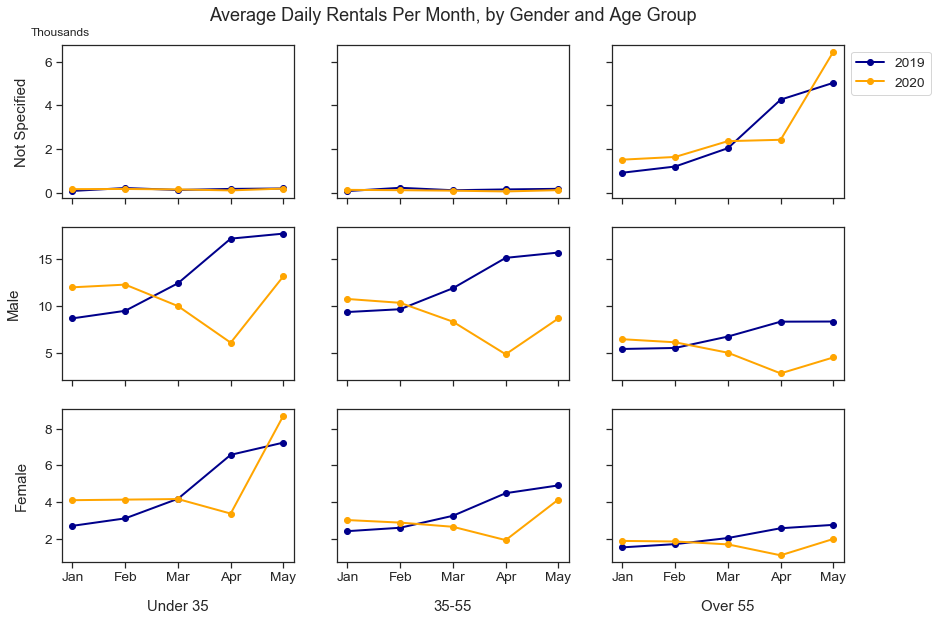

In [84]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month', 'day', 'gender', 'age_cat'], ['year'], 'rental_count', .001, impute=True)
df_pivot = df_pivot.pivot_table(index=['month', 'gender', 'age_cat'], values=[2019, 2020])

# Configure variables
x_labels = ['Under 35', '35-55', 'Over 55']
y_labels = ['Not Specified', 'Male', 'Female']
y_min, y_max = 0, 18
title = "Average Daily Rentals Per Month, by Gender and Age Group"
text = "Thousands"

# Call the helper function to make the subplots
make_subplots(x_labels, y_labels, title, text)
plt.savefig('../new_data/figures/line_rentals_age_gender.png', bbox_inches='tight');

#### Spikes in May for male & female riders under 35 and for unspecified riders 55+

Generally, the trends by age and gender appear to follow the overall rental count trends with decreases into March and April and a recovery in May. That said, there are a few patterns in the above plot worth highlighting:

1. **Male and Female Riders Under 35** - The percentage decline in rentals in April looks to be fairly consistent across age groups for both male and female riders. However, the recovery in May appears to be much more pronounced for riders under the age of 35, with counts *more than doubling* between April and May.

2. **Not Specified Riders Over 55** - Ridership in the 'Not Specified' category also sees a similar decline in April 2020, but bounces back significantly (nearly tripling) in May to surpass the number of rentals for the same month in 2019. It's also worth noting that the number of riders in the 'Not Specified' category is much larger in the 'Over 55' age group as compared to the 'Under 35' and '35-55' age groups, respectively. 


### Average daily rental duration per month, by gender and age group

Next, let's take a look at average daily rental duration to see what trends are apparent in the data.

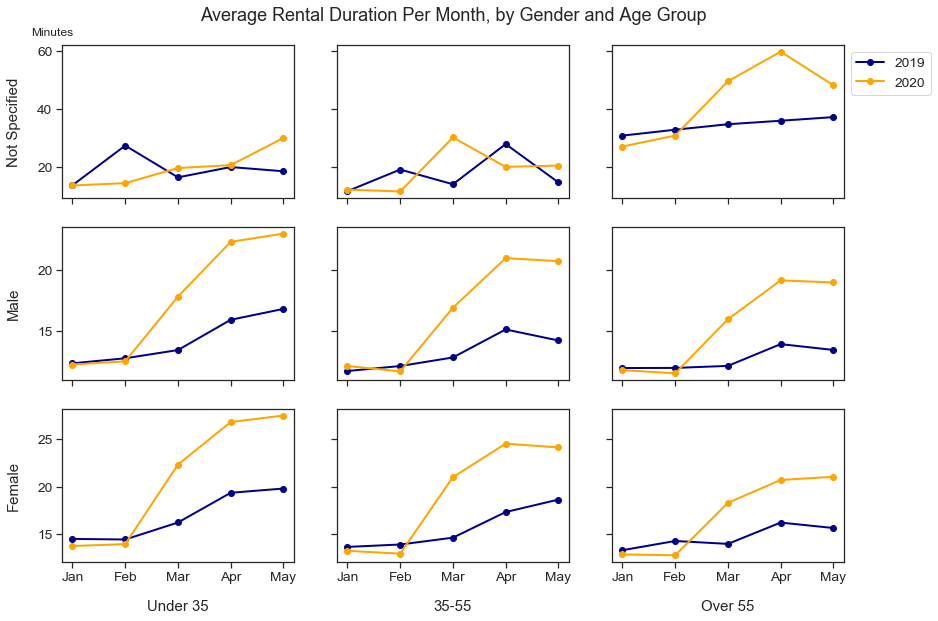

In [85]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month', 'day', 'gender', 'age_cat'], ['year'], 'tripduration', 1.667E-2,
                    impute=True, aggfunc=np.mean)
df_pivot = df_pivot.pivot_table(index=['month', 'gender', 'age_cat'], values=[2019, 2020])

# Update variables
title = "Average Rental Duration Per Month, by Gender and Age Group"
text = "Minutes"

# Call the helper function to make the subplots
make_subplots(x_labels, y_labels, title, text)
plt.savefig('../new_data/figures/line_duration_age_gender.png', bbox_inches='tight');


#### Consistent upward trend in rental duration across the board

Looking at the plots for average rental duration across age groups and gender categories, we see a fairly consistent trend for all nine subplots. That is, we see a slight decline in February 2020 (when compared to 2019), followed by an upward trend for March, April and May. The trajectory of the upward trend does vary a bit between subplots, however, no one subplot jumps out as being significantly different from the rest. 

In terms of more general trends, it does appear that the increase in duration is more pronounced for male and female riders in the 'Under 35' age group, decreasing slightly in each of the successive age groups. Again though, similar to with rental counts, we see a higher than expected number of riders in the 'Not Specified' category falling into the 'Over 55' age group.


## 5. Are there any perceptible shifts in rider behavior in terms of rides by hour of day or day of the week?

Next on our list for analysis is to review rider behaviors by hour of day and by day of the week. To simplify our analaysis a bit, we will classify day of the week into two categories - either as a weekday (i.e., Monday-Friday) or as a weekend (i.e., Saturday and Sunday). In terms of our initial assumptions and hypothesis, I would expect to see a few noticeable shifts in terms of rider behavior:

1. **Reduced activity at peak commute hours (6-9 AM) and (4-7 PM)** - As mentioned at the start, Covid-19 has resulted in many more people working remotely, which should in turn, reduce the need for a daily commute.
<br/>

2. **Reduced activity late at night (10 PM - Midnight) and early morning (Midnight - 4 AM)** - With bars and night clubs closed, and people encouraged to stay home as much as possible, it would stand to reason that many fewer people would renting bikes late at night or early in the morning.
<br/>

3. **Increased activity between early and late afternoon** - With fewer riders making a daily commute to the office, I would anticipate seeing a spike in ridership during peak business hours, as a result of people spending more time running errands and or getting exercise throughout the day.
<br/>

Let's take a look to see if any of these shifts are noticeable in the data.


### Update plotting helper function

Before we begin, we need to tweak our subplotting function to account for a change in the number of dimensions on each axis, from a 3x3 grid (3 gender categories and 3 age groups) to a 2x5 grid (weekend vs. weekday across each of the 5 months).

In [86]:
###TODO - Look for a way to consolidate 'make_subplots' and 'make_subplots2' into a single function
def make_subplots2(df, x_labels, y_labels, y_min, y_max, title, text, text_x=0.01, text_y=0.98,
                   num_rows=2, num_cols=5):
    """Returns a multi-dimensional grid of subplots
    """
    # Set x values for each hour of the day
    x = [i for i in range(24)]

    # Create figure and subplot grid
    fig, ax = plt.subplots(num_rows, num_cols, sharey='row', figsize=(12,8))
    fig.tight_layout(h_pad=2, w_pad=1)
    
    # Create subplots
    for i in range(num_rows):
        for j in range(num_cols):
            
            # Extract y values for 2019 and 2020 from pivot tables
            y1 = [df[0][df[0].index.isin([(j+1,i,n)])].iloc[0,0] for n in range(24)]
            y2 = [df[1][df[1].index.isin([(j+1,i,n)])].iloc[0,0] for n in range(24)]
            
            # Create elements to zip y values
            y = [y1, y2]
            labels = ['2019', '2020']
            colors = ['darkblue', 'orange']

            # Plot the values
            ax_loc = ax[i,j]
            for y_arr, label, color in zip(y, labels, colors):
#                 ax_loc.bar(x, y_arr, color=color, label=label, alpha=0.5)
                ax_loc.plot(x, y_arr, color=color, label=label, linewidth=1)

            # Formatting for x and y axis 
            ax_loc.set_xticks(np.linspace(0, 24, 5))
            ax_loc.set_ylim(y_min, y_max)
            ax_loc.set_xticklabels(['12am', '6am', '12pm', '6pm', ''], rotation=45, fontsize=11)

            # Set location specific plot elements
            if i == 0 and j == 0: # set yaxis label on upper left plot
                ax[0,0].text(text_x, text_y, text, fontsize=14, transform=plt.gcf().transFigure)
            if j == 0: # set y labels on left plots only
                ax_loc.set_ylabel(y_labels[i], labelpad=16)            
            if i == (num_rows-1): # set xlabels on bottom plots only
                ax_loc.set_xlabel(x_labels[j], labelpad=16)

        # Add legend and show the plot
        ax[0,2].set_title(title, x=0.5, fontsize=18, pad=24)
        ax[0,4].legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));


### Average rental count per month by hour, weekday vs. weekend


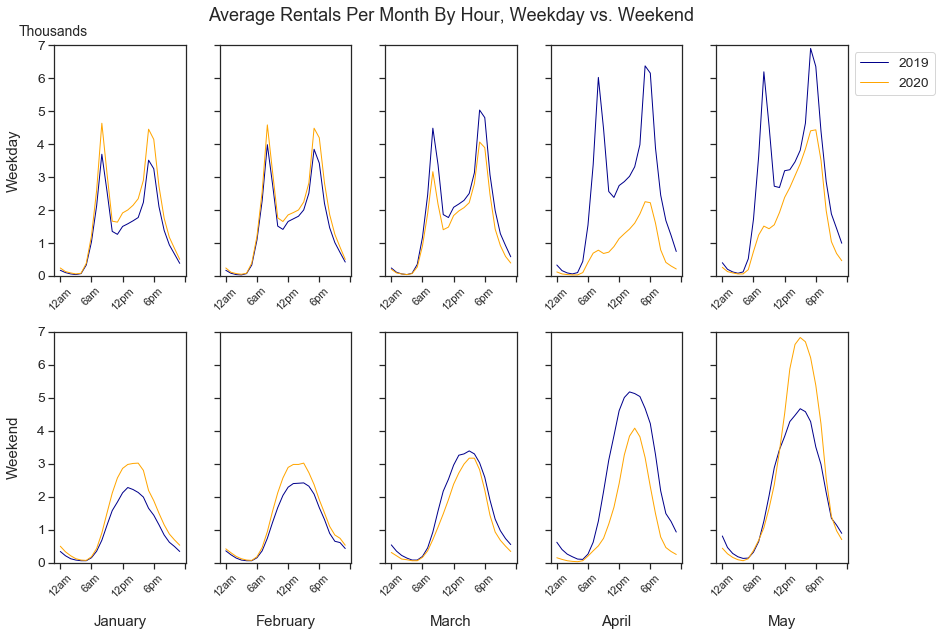

In [87]:
# Filter df by year
df_pivot_19 = df[df.year == 2019]
df_pivot_20 = df[df.year == 2020]

# Pivot df using helper function
df_pivot_19 = pivot_df(df_pivot_19, ['month', 'day', 'dow', 'hour'], ['year'], 'rental_count', 0.001)
df_pivot_19 = pivot_df(df_pivot_19, ['month', 'dow', 'hour'], pv_columns=None, pv_values=[2019],
                       scale=1, aggfunc=np.mean)

df_pivot_20 = pivot_df(df_pivot_20, ['month', 'day', 'dow', 'hour'], ['year'], 'rental_count', 0.001)
df_pivot_20 = pivot_df(df_pivot_20, ['month', 'dow', 'hour'], pv_columns=None, pv_values=[2020],
                       scale=1, aggfunc=np.mean)

# Configure variables
dfs = [df_pivot_19, df_pivot_20]
x_labels = ['January', 'February', 'March', 'April', 'May']
y_labels = ['Weekday', 'Weekend']
y_min, y_max = 0, 7
title = "Average Rentals Per Month By Hour, Weekday vs. Weekend"
text = "Thousands"

# Call the helper function to make the subplots
make_subplots2(dfs, x_labels, y_labels, y_min, y_max, title, text)
plt.savefig('../new_data/figures/line_rentals_hour_dow.png', bbox_inches='tight');


#### Changes to weekday peak rental periods, consistent weekend trends

So, how did the above assertions hold up?

1. **Reduced activity at peak commute hours (6-9 AM) and (4-7 PM)** - We do see a noticeable dropoff during peak commute hours during weekdays starting in April and continuing into May.
<br/>

2. **Reduced activity late at night (10 PM - Midnight) and early morning (Midnight - 4 AM)** - We do see a slight reduction in rentals between midnight and 4 AM for April and May (and also for March when looking at weekend days). That said, the shift appears to be more significant on weekends than on weekdays and less significant overall than the shift around commute hours.  
<br/>

3. **Increased activity between early and late afternoon** - It does not appear that we have any new spikes in ridership between early and late afternoon. The fact that we have fewer ride overall may be obscuring any trends of this sort, but it's not possible to determine that in the subplots above.
<br/>

Finally, in addition to the above points, there is noticeable jump in weekend rental counts during the month of May. 


### Average rental duration per month by hour, weekday vs. weekend


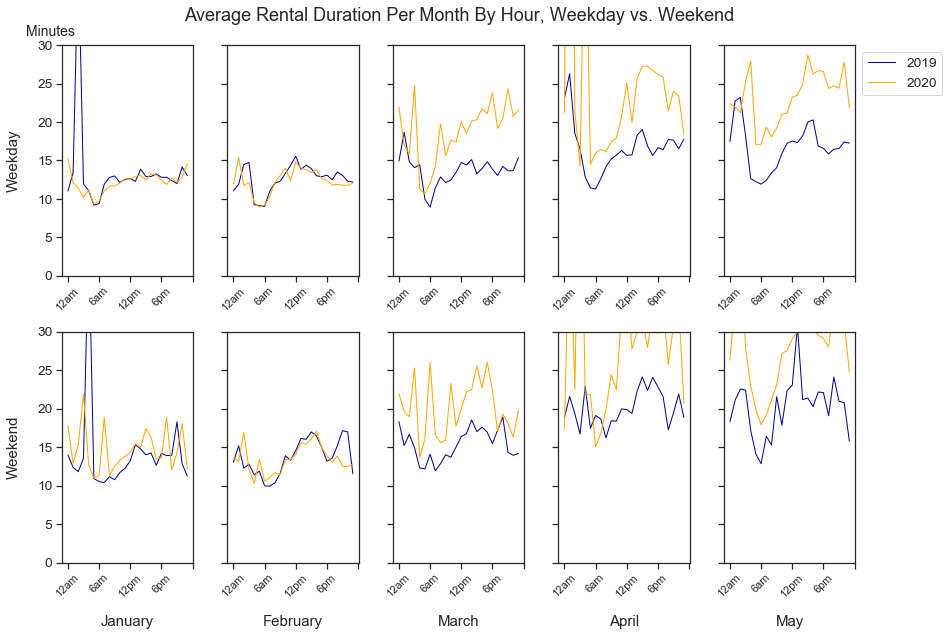

In [88]:
# Filter df by year
df_pivot_19 = df[df.year == 2019]
df_pivot_20 = df[df.year == 2020]

# Pivot df using helper function
df_pivot_19 = pivot_df(df_pivot_19, ['month', 'day', 'dow', 'hour'], ['year'], 'tripduration', 1.667E-2, 
                       aggfunc=np.mean)
df_pivot_19 = pivot_df(df_pivot_19, ['month', 'dow', 'hour'], pv_columns=None, pv_values=[2019],
                       scale=1, aggfunc=np.mean)

df_pivot_20 = pivot_df(df_pivot_20, ['month', 'day', 'dow', 'hour'], ['year'], 'tripduration', 1.667E-2, 
                       aggfunc=np.mean)
df_pivot_20 = pivot_df(df_pivot_20, ['month', 'dow', 'hour'], pv_columns=None, pv_values=[2020],
                       scale=1, aggfunc=np.mean)

# Configure variables
dfs = [df_pivot_19, df_pivot_20]
x_labels = ['January', 'February', 'March', 'April', 'May']
y_labels = ['Weekday', 'Weekend']
y_min, y_max = 0, 30
title = "Average Rental Duration Per Month By Hour, Weekday vs. Weekend"
text = "Minutes"

# Call the helper function to make the subplots
make_subplots2(dfs, x_labels, y_labels, y_min, y_max, title, text)
plt.savefig('../new_data/figures/line_duration_hour_dow.png', bbox_inches='tight');


#### A similar story, rental counts down, rental durations up

The plots above corroborate our earlier findings that while rental counts are down overall, average rental durations are consistently up. Interestingly, average rental duration appears to be up regardless of hour of day, or day of week. Although, increases are somewhat more noticeable in the late afternoon for both weekdays and weekends. This view shows a slow and steady increase in the average rental duration from March through May in 2020, with January and February durations consistent between 2019 and 2020. 


## 6. What is the estimated impact on program revenue?

So this brings us to the final question above... what effect, if any. does all of this have on estimated program revenue?

To answer this question, we need to start with a review of the Citi Bike pricing model. Citi Bike customers essentially fall into one of two categories - Subscriber and non-Subscriber. A subscriber pays and annual fee for an unlimited number of rides up to 45 minutes, and a \\$0.15 cent fee for each additional minute over 45. In contrast, non-subscribers have a couple of options, either a \\$3.00 flat fee per ride (up to 30 minutes), or a 24 hour pass for \\$12.95 with unlimited rides (up to 30 minutes) over a 24 hour period. In either case, there is a \\$0.15 cent fee for each additional minute over 30.

Due to the fact that we cannot uniquely identify riders, we will have to make a few assumptions to get to a reasonable estimate of program revenue for 2019 and 2020 (January through May only).

- **Subscribership remains flat in 2020** - The data does not provide info on the number of subscribers, so for the sake of our estimation, we will assume that subscribership remains flat for 2020 as compared to 2019.
<br/>

- **Non-subscriber ride pricing** - The data does not differentiate between the price of non-subscriber rides, i.e., whether the rides were purchased individually (\\$3.00) or as part of a 24 hr pass(\\$12.95). Since we don't have the distribution of rides in each category, and since we are only concerned with estimating the change year-over-year and not the actual amount, we will assume a base price of \\$3 per ride for non-subscribers.
<br/>

Using these assumptions, our revenue estimation process will look like this:

1. Convert trip duration to minutes (to aid in calculating overage charges)
<br/>

2. Create a function to calculate a price per ride using the assumptions above which looks like this:
    - Subscriber rides under 45 min - filtered out, assuming flat revenue for annual subscriptions
    - Subscriber rides over 45 min - \\$0.15 cents per minute over 45
    - Non-subscriber rides under 30 min - \\$3.00 base price per rental
    - Non-subscriber rides over 30 min - \\$3.00 base price per rental + \\$0.15 cents per minute over 30
<br/>

3. Filter out subscriber trips under 45 min (per the above)
<br/>

4. Use the function to estimate the price for each rental
<br/>

5. Plot the results
<br/>

Before we get started on steps 1-5 above and drop so many of the subscriber rows (step 3), let's make a copy of our original df and take a quick look at the overall trend in terms of total renters by customer type.


In [89]:
# Filter dataframe for revenue analysis and remove original df
rev_df = df[['tripduration', 'usertype', 'birth_year', 'rental_count', 'year', 'month']].copy()

# If needed to reclaim memory
# del df
# del df_pivot_19
# del df_pivot_20


### Total rentals by customer type


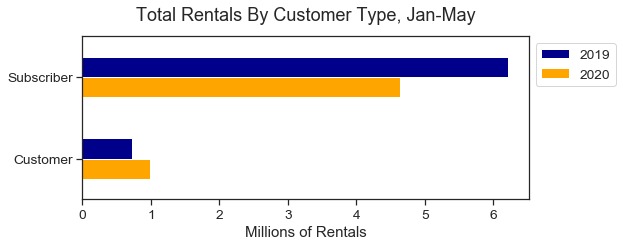

In [90]:
# Pivot df using helper function
pv_rev_df = pivot_df(rev_df, ['usertype'], ['year'], 'rental_count', 0.000001)

# Plot the data and set style
labels = ['2019', '2020']
usertypes = ['Subscriber', 'Customer']
pv_rev_df.plot(kind='barh', figsize=(8, 3), color=['darkblue', 'orange'])
plt.xlabel('Millions of Rentals')
plt.ylabel(None)
plt.yticks([0, 1], labels=usertypes)
plt.gca().invert_yaxis() # account for default reversal of the y axis values
plt.title("Total Rentals By Customer Type, Jan-May", fontsize=18, pad=16)
plt.legend(labels, title=None, loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('../new_data/figures/barh_rentals_by_usertype.png', bbox_inches='tight');

#### More subscriber rides in 2019, more non-subscribers in 2020

Looking at the above, there are over 1 million fewer rentals by subscribers in 2020 than when compared to the same period in 2019. Non-subscriber rides, however, are up by roughly a quarter million over the same time frame.


### Estimated revenue

Now comes the moment of truth... let's execute the steps above and plot our results.


In [91]:
# 1. Convert trip duration to minutes and preview
rev_df.tripduration = rev_df.tripduration / 60

# 2. Create functions for assigning price estimates
def cus_pricing(tripduration):
    """Returns the overage charge based on tripduration
    """
    if tripduration < 30:
        return 3.00
    else:
        return 3.00 + ((tripduration - 30) * 0.15)

    
def sub_pricing(tripduration):
    """Returns the overage charge based on tripduration
    """
    return (tripduration - 45) * 0.15


# 3. Filter out subscriber trips under 45 min
rev_df = rev_df[((rev_df.usertype == 0) & (rev_df.tripduration > 45) | (rev_df.usertype == 1))].reset_index(drop=True)

# 4. Create price column and estimate price for each rental
rev_df['price'] = 0.00
rev_df['price'] = np.where(rev_df['usertype'] == 0, rev_df['tripduration'].apply(sub_pricing),
                       (rev_df['price'] + rev_df['tripduration'].apply(cus_pricing)))

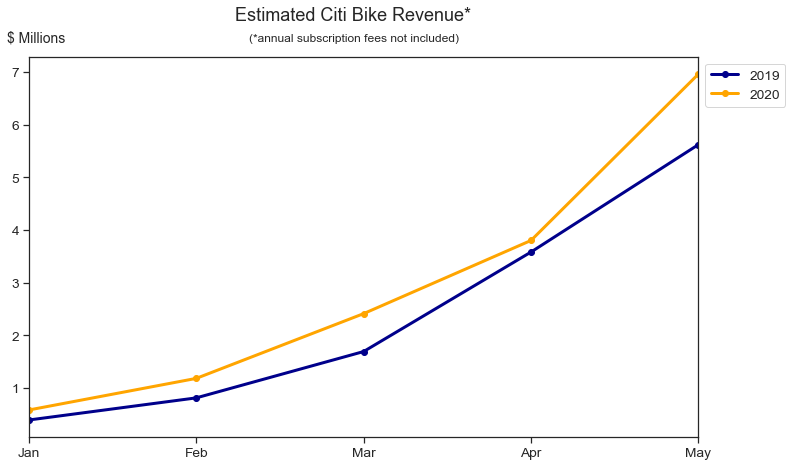

In [92]:
# 5. Plot the results

# Pivot df using helper function
pv_rev_df = pivot_df(rev_df, ['month'], ['year'], 'price', 1.00E-6, cumsum=True)

# Plot a line chart and set the chart style
pv_rev_df.plot(kind='line', linewidth=3, figsize=(12, 7), color=['darkblue', 'orange'], marker='o')

# Add labels and legend
plt.text(0.1, 0.91, '$ Millions', fontsize=14, transform=plt.gcf().transFigure)
plt.suptitle("Estimated Citi Bike Revenue*", fontsize=18, x=0.5)
plt.title("(*annual subscription fees not included)", fontsize=12, pad=16, x=0.485)
plt.xticks(np.linspace(1, 5, 5), ['Jan', 'Feb', 'Mar', 'Apr', 'May'])
plt.xlabel(None)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('../new_data/figures/line_est_revenue.png', bbox_inches='tight');


### Deep dive into trip duration numbers


In [93]:
# Total subscriber trips per year
sub_count_2019 = rev_df[(rev_df.usertype == 0) & (rev_df.year == 2019)].rental_count.sum()
sub_count_2020 = rev_df[(rev_df.usertype == 0) & (rev_df.year == 2020)].rental_count.sum()

# Count of subscriber trips > 45 min per year
sub_45_2019 = rev_df[(rev_df.usertype == 0) & (rev_df.year == 2019) & (rev_df.tripduration > 2700)]\
                     .rental_count.sum()
sub_45_2020 = rev_df[(rev_df.usertype == 0) & (rev_df.year == 2020) & (rev_df.tripduration > 2700)]\
                     .rental_count.sum()

print("Percent of Subscriber Trips Over 45 min:")
print("2019 - " + str(round((sub_45_2019 / sub_count_2019 * 100), 2)) + "%")
print("2020 - " + str(round((sub_45_2020 / sub_count_2020 * 100), 2)) + "%")

# Total non-subscriber trips per year
cus_count_2019 = rev_df[(rev_df.usertype == 1) & (rev_df.year == 2019)].rental_count.sum()
cus_count_2020 = rev_df[(rev_df.usertype == 1) & (rev_df.year == 2020)].rental_count.sum()

# Count of non-subscriber trips > 30 min per year
cus_30_2019 = rev_df[(rev_df.usertype == 1) & (rev_df.year == 2019) & (rev_df.tripduration > 1800)]\
                     .rental_count.sum()
cus_30_2020 = rev_df[(rev_df.usertype == 1) & (rev_df.year == 2020) & (rev_df.tripduration > 1800)]\
                     .rental_count.sum()

print("\n")
print("Percent of Non-Subscriber Trips Over 30 min:")
print("2019 - " + str(round((cus_30_2019 / cus_count_2019 * 100), 2)) + "%")
print("2020 - " + str(round((cus_30_2020 / cus_count_2020 * 100), 2)) + "%")

# Total subscriber overage minutes per year
sub_overage_2019 = rev_df[(rev_df.usertype == 0) & (rev_df.year == 2019) & (rev_df.tripduration > 2700)]\
                     .tripduration.sum() - (sub_45_2019 * 2700)
sub_overage_2020 = rev_df[(rev_df.usertype == 0) & (rev_df.year == 2020) & (rev_df.tripduration > 2700)]\
                     .tripduration.sum() - (sub_45_2020 * 2700)

print("\n")
print("Subscriber, total overage minutes:")
print("2019 - " + str(round(sub_overage_2019, 2)))
print("2020 - " + str(round(sub_overage_2020, 2)))

# Total subscriber overage minutes per year
cus_overage_2019 = rev_df[(rev_df.usertype == 1) & (rev_df.year == 2019) & (rev_df.tripduration > 1800)]\
                     .tripduration.sum() - (cus_30_2019 * 1800)
cus_overage_2020 = rev_df[(rev_df.usertype == 1) & (rev_df.year == 2020) & (rev_df.tripduration > 1800)]\
                     .tripduration.sum() - (cus_30_2020 * 1800)

print("\n")
print("Non-Subscriber, total overage minutes:")
print("2019 - " + str(round(cus_overage_2019, 2)))
print("2020 - " + str(round(cus_overage_2020, 2)))

Percent of Subscriber Trips Over 45 min:
2019 - 1.34%
2020 - 0.38%


Percent of Non-Subscriber Trips Over 30 min:
2019 - 0.15%
2020 - 0.13%


Subscriber, total overage minutes:
2019 - 4012857.2
2020 - 2224519.28


Non-Subscriber, total overage minutes:
2019 - 5862880.28
2020 - 7193278.38


In [94]:
# Pivot df using helper function 
df_pivot_tot = pivot_df(df, ['usertype'], ['year'], 'tripduration', 1.667E-8, impute=True)
df_pivot_avg = pivot_df(df, ['usertype'], ['year'], 'tripduration', 1.667E-2, aggfunc=np.mean)

df_pivot_avg

year,2019,2020
usertype,,
0,13.23,15.24
1,38.99,40.83



#### TODO - Add some analysis on the deep dive into duration numbers



## 7. Conclusion

Based on our pricing assumptions and the analysis above, the initial hypothesis appears to be incorrect. The increase in overall customer rentals (estimated at \\$3.00 per ride) in 2020 along with the increase in average rental duration (\\$0.15 cents per minute in overage fees) reaults in estimated revenue for 2020 that is above the estimation for 2019 over the same period. This result is surprising given the sudden, dramatic and wide-spread public impacts of Covid-19 (and in NYC, in particular).

Obviously, the limited customer-specific data prevents us from drawing any definite conclusions about Citi Bike program revenue and associated program health. However, it appears that the program is going strong in the face of this unprecedented event affecting public health. 

Before wrapping up, there are a few notes to highlight regarding limitations which may skew the results of this analysis when compared to *actual* program revenue.

1. **Subscriber count** - Although we made the assumption that subscribership remained flat in 2020 as compared to 2019. It's quite possible this is not the case. Subscribers impacted by Covid-19 may have cancelled or paused subscriptions in the wake of the pandemic, resulting in an overall decline in program revenue. In contrast, subcribership may have spiked in the wake of the pandemic as the number of available transportation options temporarily declined (e.g., public transit closures and/or schedule reductions).
<br/>

2. **Non-subscriber rentals** - The decision to classify all non-subscriber trips as \\$3.00 single trips rather than \\$12.95 day pass trips may have skewed our projections. Historically, I believe there is a relatively even split between single rentals and daily pass rentals, but it's conceiveable that Covid-19 resulted in some dramatic shift to this trend one way or the other.
<br/>

3. **Free or other discounted trips** - In my research, I did not find any evidence to suggest that rentals were offered for free or at a reduced cost over the past few months, however, it's possible this was the case. If so, any large-scale discount applied to the data would obviously result in a corresponding reduction in actual revenue for the period of time affected, making my estimations more favorable when compared with reality.
<br/>

The list above is by no means exhaustive and it's possible that other factors beyond the vision of this analysis could have played a part in the actual result. In addition to further analysis with respect to revenue estimations, the following is a list of potential future extensions for this work:

- **Detailed pricing analysis / revenue estimation** if subscriber counts or detailed pricing data becomes available
<br/>

- **Geographic analysis** to understand shifts in user activity and rental volumes between stations, borroughs, zip codes
<br/>

- **Birth year anomaly investigation** into the odd spike in riders with a birth year of 1969; and potentially related, the disproportionately high number of riders with a gender of `Not Specified` in the age group of `Over 55`
<br/>

- **Incorporation of data from future months** to see how the trends observed in this analysis play out over time
<br/>

- **Comparison with other programs** in the US, or worldwide
<br/>


Thanks for reading! 

## Appendix A: Prep for further analysis

Rebuild df, limited to only what is needed for Appendix analysis

In [95]:
# # Function for reading in and processing data files
# def read_and_process(filepath, col_types, drop_cols, get_stations=False):
#     '''Reads in and processes CitiBike monthly csv data files and returns a 
#     dataframe containing the list of rentals for a given month
#     '''
#     # Read in the data
#     temp_df = pd.read_csv(filepath) 
    
#     # Drop rows with null values
#     temp_df = temp_df.dropna()
    
#     # Convert starttime columns to datetime
#     temp_df.starttime = pd.to_datetime(temp_df.starttime, infer_datetime_format=True)
    
#     # Convert usertype column to binary
#     temp_df.usertype = temp_df.usertype.map({"Subscriber": 0, "Customer": 1})
    
#     # Convert column dtypes
#     temp_df = temp_df.astype(col_types)
    
#     if get_stations == True:  # Process station data
#         temp_stations = process_station_data(temp_df)  
    
#     # Drop unnecessary or redundant columns
#     temp_df = temp_df.drop(drop_cols, axis=1)
    
#     # Rename columns to replace spaces with "_"
#     temp_df.columns = temp_df.columns.str.replace(" ", "_")
    
#     # Return df object(s) based on params
#     if get_stations == True: 
#         return temp_df, temp_stations
#     else:
#         return temp_df


# # Function for abstracting out station-related data for location-based analysis
# def process_station_data(df):
#     '''Processes and abstracts station-related data and returns as a separate dataframe
#     '''
#     # New column names
#     cols = ['id', 'name', 'lat', 'lon']

#     # Temp df for start stations
#     start_stations = df[['start station id', 'start station name',
#                          'start station latitude', 'start station longitude']]
#     start_stations.columns = cols
#     start_stations = start_stations.drop_duplicates()

#     # Temp df for end stations
#     end_stations = df[['end station id', 'end station name',
#                        'end station latitude', 'end station longitude']]
#     end_stations.columns = cols
#     end_stations = end_stations.drop_duplicates()
    
#     # Concatenate the start/end station dfs and drop dups 
#     temp_stations = pd.concat([start_stations, end_stations],
#                               ignore_index=True).drop_duplicates()
    
#     return temp_stations

In [96]:
# # Dictionary of columns and optimal dtypes
# col_types = {'start station id' : 'int', 'end station id': 'int',
#              'birth year': 'int', 'gender': 'int8', 'bikeid': 'int'}

# # Create list of columns to drop
# drop_cols = ['stoptime', 'start station name', 'start station latitude',
#              'start station longitude', 'end station name', 'end station latitude',
#              'end station longitude']

# # Read in and process the data
# data_files = glob.glob('../data/' + "*.csv")
# rentals_dfs = []

# for file in data_files:
#     rentals_df = read_and_process(file, col_types, drop_cols)
#     rentals_dfs.append(rentals_df)

# # Concatentate the list of temp dfs
# df = pd.concat(rentals_dfs, ignore_index=True)

# # Check out the data!
# rows = df.shape[0]
# print(str(rows) + " Rows")

In [97]:
# # Remove outlier rentals with above 120 min
# df = df[(df.tripduration >= 90) | (df.tripduration <= 7200)]

# # Remove outlier rentals with riders older than 90
# df = df[df.birth_year >= 1930]

In [98]:
# # Sort the dfs by starttime
# df = df.sort_values(by=['starttime']).reset_index(drop=True)

# # Create a column to facilitate totaling rental count
# df['rental_count'] = 1

# # Create a function to get the dow of the week as an int value
# def get_dow(starttime):
#     """Returns 0 for weekdays or 1 for weekend days when passed a datetime object
#     """
#     if starttime.weekday() < 5:
#         return 0
#     else:
#         return 1

# # Create additional date-related columns
# df['day'] = df.starttime.dt.day
# df['month'] = df.starttime.dt.month
# df["year"] = df.starttime.dt.year
# df['dow'] = df.starttime.apply(get_dow)

# # Drop columns not used in analysis
# df = df.drop('starttime', axis=1)

# # Preview final df
# df.head()

## Appendix B: Geographic Data

TBD... additional geographic analysis

- Station popularity (start, end, any changes yoy)
- Route popularity and any yoy changes
- Chloropleth map with animation or interaction to show changes over time

In [99]:
### TBD

## Appendix C: Age analysis

TBD... additional analysis to look into the birth year / age anomalies in the data.

- Check yoy differences
- Check usertype differences
- Research possible causes

In [100]:
# # Create a new df to facilitate analysis based on age
# temp_df = df[['birth_year', 'year', 'rental_count']].copy()

# # Create a new column for age based on rental year and birth year
# temp_df['age'] = temp_df['year'] - temp_df['birth_year']

# # Filter df, group by age and look at the top 10 results
# temp_df = temp_df[['age', 'rental_count']]
# temp_df.groupby(['age']).rental_count.sum().sort_values(ascending=False).head(10)
# # temp_df.head()

In [101]:
# # Plot a histogram of the results
# temp_df['age'].hist(bins=70, range=(15,85), color='darkblue')
# sns.set_style('ticks')
# plt.xlim(15,85)
# plt.title('Age Distribution');